In [1]:
import numpy as np
import pandas as pd

from gwpy.segments import DataQualityFlag
from gwpy.time import tconvert, to_gps, from_gps

import bisect
import json, urllib.request, urllib.error

In [2]:
def get_GWTCs(start_time, end_time, time_ranges = [1126051217, 1137254417, 1164556817, 1187733618, 1238166018, 1253977218, 1256655618, 1269363618], GWTC_list = [None,'GWTC-1',None,'GWTC-1',None,'GWTC-2.1',None,'GWTC-3',None]):
    """
    Finds the GWTC tag(s) where the data for the given GPS time intervals can be found using https://www.gw-openscience.org/eventapi/html/.

    Parameters
    ----------
    start_time : int
        Start time of time interval (GPS time).
    end_time : int
        End time of time interval (GPS time).
    time_ranges : List of int, optional
        List of begin and end times of intervals of tags. 
        Fill in like: [begin_1, end_1, begin_2, end_2, ... , begin_n, end_n].
        If changed from default must change GWTC_list accordingly!
        The default is [1126051217, 1137254417, 1164556817, 1187733618, 1238166018, 1253977218, 1256655618, 1269363618].
    GWTC_list : TYPE, optional
        List of None and GWTC tags of time intervals in time_ranges. 
        Fill in like: [None, tag_1, None, tag_2, ... , None, tag_n]. 
        If changed from default must change time_ranges accordingly!
        The default is [None,'GWTC-1',None,'GWTC-1',None,'GWTC-2.1',None,'GWTC-3',None].

    Returns
    -------
    tags : List of str
        List of desired GWTC tag(s).

    """
    
    assert start_time <= end_time, "start_time has to be smaller than end_time"
    #assert len(time_ranges) == len(GWTC_list), "time_ranges and GWTC_list should have same length"
    
    start_idx = bisect.bisect_left(time_ranges, start_time)
    end_idx = bisect.bisect_left(time_ranges, end_time)
    
    tags = [gwtc for gwtc in GWTC_list[start_idx:end_idx+1] if gwtc is not None]
    
    return tags

def get_event_times(start_time, end_time, margin=300, observation_run = None, event_type = 'confident'):
    """
    Get the times of (confident) GW events within GPS time interval [start_time, end_time]

    Parameters
    ----------
    start_time : int
        Start GPS time of interval.
    end_time : int
        End GPS time of interval.
    margin : int, optional
        Margin around confirmed event. The default is 300.
    observation_run : str, optional
        Name of the desired observation run (not needed). The default is None.
    event_type : TYPE, optional
        Type of event catalog to retrieve data from (other options is <marginal>). The default is 'confident'.

    Returns
    -------
    event_times : List of int
        List of GPS times of events within given GPS time interval.
    margin : int
        Margin around confirmed event. The default is 300.

    """
    
    GWTCs = get_GWTCs(start_time, end_time)
    
    event_times = []
    for GWTC in GWTCs:
        url = f'https://www.gw-openscience.org/eventapi/json/{GWTC}-{event_type}/'

        req = urllib.request.Request(url)
        
        try:
            response = urllib.request.urlopen(req)
        except urllib.error.HTTPError as e:
            print(f'Error code: {e}')
            continue #return event_times
        except urllib.error.URLError as e:
            print(f'Reason: {e.reason}')
            continue #return event_times
        else:
            data = json.loads(response.read().decode('utf-8'))
        
        
        for event in data['events'].items():
            time = event[1]['GPS']
            if time + margin >= start_time and time - margin <= end_time:
                event_times.append(time)
    
    return event_times, margin

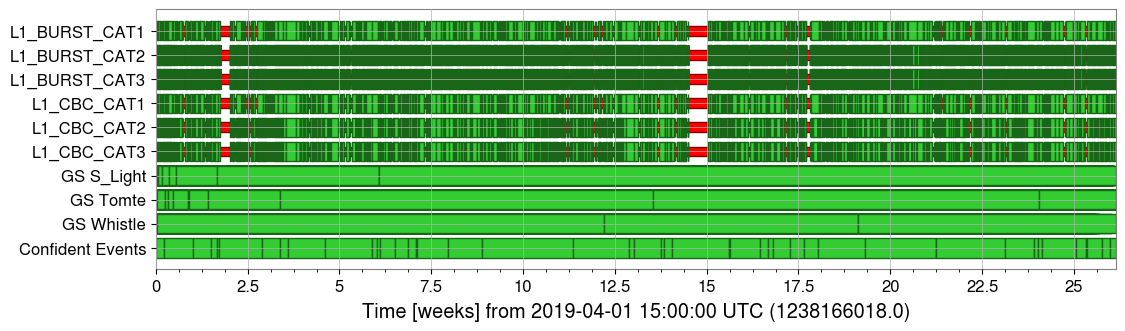

In [3]:
start = 1238166018 # UTC: 2019-04-01T15:00:00
end = 1253977218 # UTC: 2019-10-01T15:00:00

gs_triggers = pd.read_csv('/home/robin.vanderlaag/wp5/strain_fractals/condor_data/gspyO3A.csv')
flags = ['L1_CBC_CAT3', 'L1_CBC_CAT2', 'L1_CBC_CAT1', 'L1_BURST_CAT3', 'L1_BURST_CAT2', 'L1_BURST_CAT1']

# other flags you could pass
#flags_closed_cat2 = ['DCH-THUNDER_MIC_BP_GT_300','DCH-THUNDER_EY_MIC_BP_GT_250','DCH-TR_X_LOUD_GLITCHES','DCH-WHISTLES','DCH-WHITENED_RF45_AM_CTRL_GT_1P75','DCH-EARTHQUAKE_CS_Z_BLRMS_GT_600']
#flags_closed_cat1 = ['DCH-FORKLIFT','DCH-NON_O3_STANDARD_CONFIG','DCH-LN2_TRUCK','DCH-HIGH_VIOLINS','DCH-SEVERE_WHISTLES_FEB4','DCH-SEVERE_SCATTERING']

eventlist, _ = get_event_times(start, end)
# create a DQF for all confident events and a 4 minute region around them
event_dqf = ~DataQualityFlag(name='Confident Events', known=[(start, end)], active=[(event-120, event+120) for event in eventlist])
plot = event_dqf.plot() # plotting
ax = plot.gca()

# DQF's for the 3 glitch classes we want to avoid
whistle_df = gs_triggers[(gs_triggers['label']=='Whistle') & (gs_triggers['GPStime']>=start) & (gs_triggers['GPStime']<=end)]
dqf_whistle = ~DataQualityFlag(name='GS Whistle', known=[(start, end)], active=[(trigger-dur/2, trigger+dur/2) for trigger, dur in zip(whistle_df['GPStime'].to_numpy(), whistle_df['duration'].to_numpy())])
ax.plot(dqf_whistle)
tomte_df = gs_triggers[(gs_triggers['label']=='Tomte') & (gs_triggers['GPStime']>=start) & (gs_triggers['GPStime']<=end)]
dqf_tomte = ~DataQualityFlag(name='GS Tomte', known=[(start, end)], active=[(trigger-dur/2, trigger+dur/2) for trigger, dur in zip(tomte_df['GPStime'].to_numpy(), tomte_df['duration'].to_numpy())])
ax.plot(dqf_tomte)
slight_df = gs_triggers[(gs_triggers['label']=='Scattered_Light') & (gs_triggers['GPStime']>=start) & (gs_triggers['GPStime']<=end)]
dqf_slight = ~DataQualityFlag(name='GS S_Light', known=[(start, end)], active=[(trigger-dur/2, trigger+dur/2) for trigger, dur in zip(slight_df['GPStime'].to_numpy(), slight_df['duration'].to_numpy())])
ax.plot(dqf_slight)



all_dqf = None
for flag in flags:
    dqf_open = DataQualityFlag.fetch_open_data(flag, start, end)
    ax.plot(dqf_open)
    if all_dqf is None:
        all_dqf = dqf_open
    else:
        all_dqf = all_dqf & dqf_open

ax.set_epoch(start)
plot.show()

In [4]:
all_glitches = gs_triggers[(gs_triggers['label']=='Whistle') | (gs_triggers['label']=='Tomte') | (gs_triggers['label']=='Scattered_Light')]
all_glitches = all_glitches[(all_glitches['GPStime']>=start) & (all_glitches['GPStime']<=end)]

found_idx = []

# the segments from all_dqf might still contain some glitches
# removing those here
segs = list(all_dqf.active)
clean_segs = []
while len(segs) > 0:
    print(f"{len(segs):05d}", end='\r')
    cur_seg = segs.pop(0)
    temp_df = all_glitches[(all_glitches['GPStime']>=float(cur_seg[0])) & (all_glitches['GPStime']<=float(cur_seg[1]))]
    if len(temp_df) > 0:
        idx = temp_df['GPStime'].idxmin()
        if idx in found_idx:
            print('Whoops, something went wrong')
            break
        else:
            found_idx.append(idx)
        new_seg1 = (cur_seg[0],temp_df['GPStime'].loc[idx]-temp_df['duration'].loc[idx]/2)
        new_seg2 = (temp_df['GPStime'].loc[idx]+temp_df['duration'].loc[idx]/2, cur_seg[1])
        
        segs.append(new_seg1)
        segs.append(new_seg2)
    else:
        clean_segs.append([float(cur_seg[0]), float(cur_seg[1])])
clean_segs = np.asarray(clean_segs)


In [6]:
# sanity check, not necessary

i=0
for seg in clean_segs:
    s, e = float(seg[0]), float(seg[1])
    temp_df = all_glitches[(all_glitches['GPStime']>=s) & (all_glitches['GPStime']<=e)]
    if len(temp_df) == 0:
        i+=1
    else:
        print(len(temp_df))
print(i, len(clean_segs))

46500 46500


In [ ]:
np.save('clean_segments_O3A-test.npy', clean_segs)